In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
from sklearn.feature_extraction.text import TfidfVectorizer
## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
# ! pip install xlrd
# ! pip install openpyxl
## lda 
from gensim import corpora
import gensim
import plotnine
from plotnine import *
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## define constants and pathnames
GITHUB_DATA_PATH = "../data/"
DROPBOX_DATA_PATH = "../../../qss20_finalproj_rawdata/textasdata/"
MERGED_TEXT_JOBS_PKL = "../merged_addendums_jobdisclosures.pkl"
MERGED_TEXT_JOBS_CSV = "../merged_addendums_jobdisclosures.csv"


MERGED_TEXT_JOBS_PKL_DB = DROPBOX_DATA_PATH + "merged_addendums_jobdisclosures.pkl"

# Functions

In [2]:
## Text Processing
def processtext(row, colname, stopword_list,indicator, min_token_length = 4):
    
    ## get string form of listing
    string_of_col = str(row[colname]).lower()
    try:
        ## remove stopwords 
        remove_stop = [word for word in wordpunct_tokenize(string_of_col)
                      if word not in stopword_list]
        if indicator=="stem":
            processed_string = " ".join([porter.stem(i) 
                        for i in remove_stop if 
                        i.isalpha() and len(i) >= min_token_length])
        return(processed_string)
    except:
        processed_string = "" # to handle data errors where not actually text
        return(processed_string)


# Load merged data from previous script

In [3]:
LOAD_LOCAL = False
if LOAD_LOCAL:
    merged_data = pd.read_pickle(MERGED_TEXT_JOBS_PKL)
else:
    merged_data = pd.read_pickle(MERGED_TEXT_JOBS_PKL_DB)
    
merged_data.shape

# # test csv; same num rows so should be fine to load as alternative if needed
# merged_data_csv = pd.read_csv(DROPBOX_DATA_PATH + MERGED_TEXT_JOBS_CSV)
# # merged_data_csv.shape

(13127, 143)

# Preprocess text

In [4]:
RUN_WITH_SAMPLE = True
if RUN_WITH_SAMPLE:
    merged_data = merged_data.sample(n = 500)


In [5]:
work_pattern = r"[a-zA-Z]*work[a-zA-Z]*"
all_listings = "".join(merged_data.JOB_DESCRIPTION)
all_tokens = word_tokenize(all_listings)

all_matches_work = [one_word for one_word in all_tokens if 
                   re.match(work_pattern, one_word)]

other_stopwords = ["after", "before", "employer", "employ", "job", "although", "provide", "complete","hour","time",
                  "begin","list","require","transportation"]+ all_matches_work

list_stopwords = stopwords.words("english")

stopwords_complete = list_stopwords + other_stopwords
    
porter = PorterStemmer()


In [6]:

merged_data['text_preprocess'] = merged_data.apply(processtext,
                             axis = 1,
                             args = ["JOB_DESCRIPTION", stopwords_complete,"stem"])
merged_data.head()


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,HOURLY_SCHEDULE_BEGIN,HOURLY_SCHEDULE_END,TRLA,JOB_DESCRIPTION,raw_text_length,text_preprocess
9485,H-300-19336-174410,Determination Issued - Certification (Expired),2019-12-13 14:27:37.460,2020-01-15 00:00:00.000,Association - Joint Employer,N,Seasonal,N,"Two Lakes Vineyard Management, Inc.",NaN,...,16074745030,merideth.stanton@boundarybreaks.com,NaN,2.0,NaN,NaN,False,Continuation of job description: Workers are e...,3889,continu descript expect least number hour day ...
7487,H-300-20002-229277,Determination Issued - Certification,2020-01-15 09:41:56.820,2020-02-14 00:00:00.000,Individual Employer,Y,Seasonal,N,Kenney Book Farms,NaN,...,13184812783,ressiebook@gmail.com,http://www.laworks.net/,1.0,NaN,NaN,True,Workers who qualify for inbound and/or outboun...,2907,qualifi inbound outbound travel reimburs entit...
1008,H-300-20178-682303,Determination Issued - Certification,2020-06-29 12:54:00.480,2020-08-10 00:00:00.000,Individual Employer,Y,Seasonal,N,Valley Produce Harvesting & Hauling Co,NaN,...,15619935802,NaN,https://seasonaljobs.dol.gov/,1.0,NaN,NaN,False,"Full Crop Commitment: This is regular work, s...",22795,full crop commit regular hour monday saturday ...
4926,H-300-20044-319658,Determination Issued - Certification,2020-02-24 15:01:03.540,2020-03-11 00:00:00.000,Association - Agent,N,Seasonal,N,Potentiality Orchards,NaN,...,15096690703,joshkoempel@hotmail.com,NaN,0.0,NaN,NaN,False,Housing has been (or will be) inspected by the...,24585,hous inspect appropri state agenc compli appli...
706,H-300-20192-707947,Determination Issued - Certification,2020-07-10 17:17:23.550,2020-07-31 00:00:00.000,Association - Joint Employer,N,Seasonal,N,WESTERN RANGE ASSOCIATION,NaN,...,12085952226,applicants@westernrange.net,NaN,0.0,NaN,NaN,False,ELECTRONIC COMMUNICATIONCell phones are provid...,3046,electron communicationcel phone provid without...


In [7]:
## rj - above step takes awhile even on sample
## so writing; as a flag, this is with the sample
merged_data.to_pickle(DROPBOX_DATA_PATH + "merged_addendums_preprocessed.pkl")

# Subset Merged_Data to TRLA and NonTRLA States

In [8]:
# TRLA
merged_TRLA=merged_data[merged_data.TRLA==True]
# NonTRLA
merged_nonTRLA=merged_data[merged_data.TRLA==False]

# Raw term frequency (Tf-Idf)

In [9]:
vectorizer = TfidfVectorizer()
def tfidf_topwords(df,label):
    tf_idf = vectorizer.fit_transform(df['text_preprocess'])
    top_words = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
    stored=top_words.sum(axis=0).sort_values(ascending=False).head(10)
    plot=stored.plot.bar(title=label)
    plot.set_xlabel('Words')
    plot.set_ylabel('Tf-idf Score')
    fig = plot.get_figure()
    fig.savefig("../output/" + label+".png")

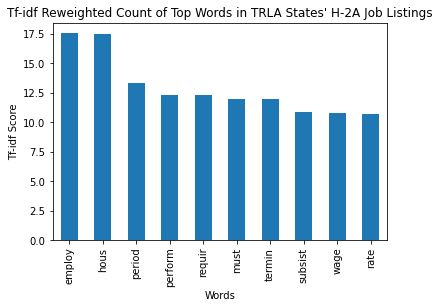

In [10]:
tfidf_topwords(merged_TRLA,"Tf-idf Reweighted Count of Top Words in TRLA States' H-2A Job Listings")

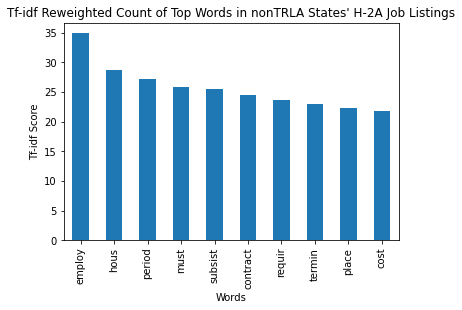

In [11]:
tfidf_topwords(merged_nonTRLA,"Tf-idf Reweighted Count of Top Words in nonTRLA States' H-2A Job Listings")

# Investigate the stemmed word "termin" in the original corpus

In [15]:
## works now :) 
pd.set_option('display.max_colwidth', None)
merged_data.loc[merged_data.JOB_DESCRIPTION.str.contains("termin"),
               "JOB_DESCRIPTION"].head(2)

## rj stopped here

7487                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

# LDA Topic Modeling

try to merge the topic model and plot into a single function.....

In [145]:
## topic modeling (TRLA states)
def topic_model(df):
    df = df[df.text_preprocess != ""].copy()
    tokenized_text = [wordpunct_tokenize(one_text) for one_text in 
                                      df.text_preprocess]
    text_proc_dict = corpora.Dictionary(tokenized_text)
    text_proc_dict.filter_extremes(no_below = round(df.shape[0]*0.02),
                             no_above = round(df.shape[0]*0.98))
    corpus_fromdict_proc = [text_proc_dict.doc2bow(one_text) 
                   for one_text in tokenized_text]
    ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict_proc, 
                                         num_topics = 3, id2word=text_proc_dict, 
                                         passes=6, alpha = 'auto',
                                        per_word_topics = True)
    topics_fromshow2 = [ldamod.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]
    return(topics_fromshow2)
    

[[('avail', 0.13801399),
  ('vari', 0.13096412),
  ('mechan', 0.13005942),
  ('complet', 0.086956784),
  ('cont', 0.0858013),
  ('physic', 0.07311963),
  ('threaten', 0.071055144),
  ('anoth', 0.071053244),
  ('tani', 0.062188916),
  ('must', 0.037061933)],
 [('right', 0.1849868),
  ('domest', 0.18459341),
  ('reserv', 0.18024905),
  ('assign', 0.10915622),
  ('employ', 0.10508352),
  ('provid', 0.08860646),
  ('wage', 0.07831296),
  ('offer', 0.06143265),
  ('intend', 0.00069378497),
  ('advanc', 0.00041423604)],
 [('intend', 0.19026962),
  ('appli', 0.19015312),
  ('legal', 0.1703398),
  ('cost', 0.13922726),
  ('hous', 0.09754111),
  ('rule', 0.07484597),
  ('advanc', 0.07016637),
  ('provid', 0.060847647),
  ('must', 0.00043688805),
  ('tobacco', 0.00038652122)]]

[[('complet', 0.28184053),
  ('cont', 0.27807269),
  ('tobacco', 0.098158844),
  ('nworker', 0.08964566),
  ('advanc', 0.08651167),
  ('pull', 0.07975926),
  ('sucker', 0.075924136),
  ('cost', 0.0017149667),
  ('appli', 0.0005278801),
  ('legal', 0.00050250813)],
 [('avail', 0.17662378),
  ('vari', 0.16760659),
  ('mechan', 0.16644827),
  ('intend', 0.09267027),
  ('appli', 0.09242935),
  ('legal', 0.08280956),
  ('assign', 0.04754365),
  ('must', 0.047468845),
  ('employ', 0.046281256),
  ('provid', 0.042010527)],
 [('physic', 0.11596319),
  ('anoth', 0.112693),
  ('threaten', 0.11268812),
  ('right', 0.09984538),
  ('domest', 0.09963726),
  ('tani', 0.09863244),
  ('reserv', 0.09728652),
  ('cost', 0.08326913),
  ('hous', 0.058702007),
  ('rule', 0.04331523)]]

[[('termin', 0.1855847),
  ('hous', 0.09984179),
  ('cost', 0.09339592),
  ('offer', 0.07892523),
  ('equip', 0.06888756),
  ('paid', 0.067273006),
  ('wage', 0.057870317),
  ('tool', 0.05747532),
  ('higher', 0.054836445),
  ('advanc', 0.04532365)],
 [('requir', 0.12843855),
  ('commun', 0.10474372),
  ('electron', 0.10374583),
  ('phone', 0.09972531),
  ('compens', 0.097199015),
  ('ncell', 0.096463576),
  ('along', 0.07765691),
  ('employ', 0.069278374),
  ('complet', 0.06797231),
  ('must', 0.063816585)],
 [('advanc', 0.15526477),
  ('subsist', 0.11446041),
  ('inbound', 0.087154746),
  ('incom', 0.07337365),
  ('outbound', 0.071385816),
  ('qualifi', 0.067975),
  ('transportatio', 0.05873029),
  ('reason', 0.0535615),
  ('provid', 0.052560326),
  ('state', 0.043380424)]]

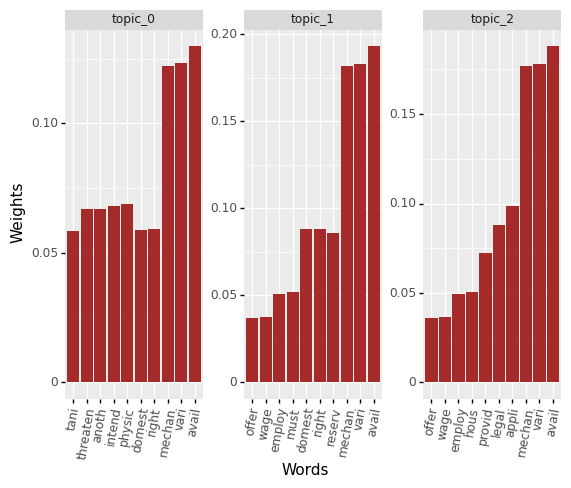

<ggplot: (8760118742781)>

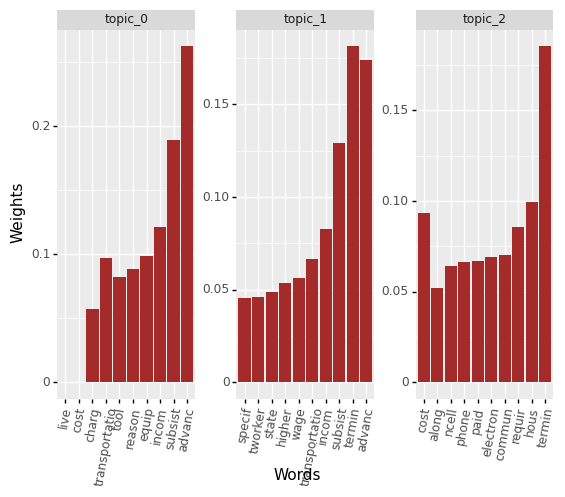

<ggplot: (8760118475743)>

In [153]:
#function to create table suitable for plotting LDA modeling's result
def df_onetopic(one_listoftup, i):
    words = [one_tup[0] for one_tup in one_listoftup]
    weights = [one_tup[1] for one_tup in one_listoftup]
    words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
    words_weights_df['topic'] = "topic_" + str(i)
    return(words_weights_df)
topic_model(merged_TRLA)
topic_model(merged_nonTRLA)

#plot TRLA model
all_summary = []
for i in range(0, len(topic_model(merged_TRLA))):
    one_summary = df_onetopic(topic_model(merged_TRLA)[i], i)
    all_summary.append(one_summary)
all_summary_df = pd.concat(all_summary)
ggplot(all_summary_df) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights")


#plot nonTRLA model
all_summary = []
for i in range(0, len(topic_model(merged_nonTRLA))):
    one_summary = df_onetopic(topic_model(merged_nonTRLA)[i], i)
    all_summary.append(one_summary)
all_summary_df = pd.concat(all_summary)
ggplot(all_summary_df) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights")



In [ ]:
# Code Below Is Draft (uncleaned)

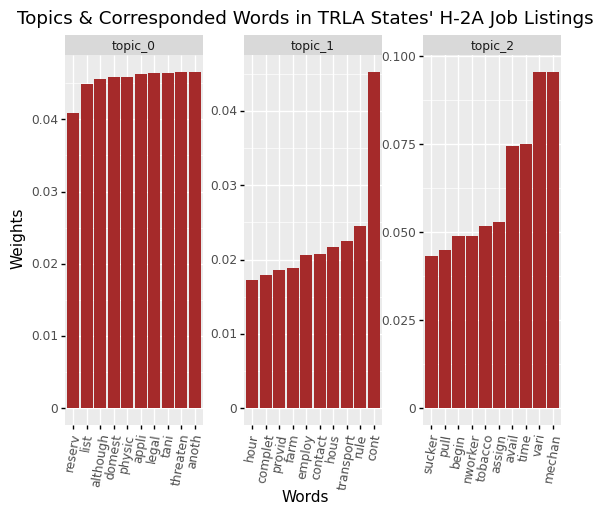

<ggplot: (8769739236602)>

In [37]:
import plotnine
from plotnine import *

ggplot(all_summary_df) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights",title="Topics & Corresponded Words in TRLA States' H-2A Job Listings")

In [38]:
## topic modeling (nonTRLA states)

merged_nonTRLA = merged_nonTRLA[merged_nonTRLA.text_preprocess != ""].copy()

tokenized_text_nonTRLA = [wordpunct_tokenize(one_text) for one_text in 
                                      merged_nonTRLA.text_preprocess]

## preprocess and estimate topicmod
### create dictionary
text_proc_dict_nonTRLA = corpora.Dictionary(tokenized_text_nonTRLA)
### filter dictionary- using 2% as bounds
text_proc_dict_nonTRLA.filter_extremes(no_below = round(merged_nonTRLA.shape[0]*0.02),
                             no_above = round(merged_nonTRLA.shape[0]*0.98))

### create corpus from dictionary
corpus_fromdict_proc_non = [text_proc_dict_nonTRLA.doc2bow(one_text) 
                   for one_text in tokenized_text_nonTRLA]

tfidf_non = models.TfidfModel(corpus_fromdict_proc_non)
corpus_tfidf_non = tfidf[corpus_fromdict_proc_non]

lda_model_tfidf_non = gensim.models.LdaMulticore(corpus_tfidf_non, num_topics=3, id2word=text_proc_dict_nonTRLA, passes=6,
                                        per_word_topics = True, random_state = 91988)

topics_nontrla = lda_model_tfidf_non.print_topics()
for topic in topics_nontrla:
    print(topic)

(0, '0.066*"advanc" + 0.033*"transport" + 0.029*"complet" + 0.028*"provid" + 0.028*"hous" + 0.026*"harvest" + 0.026*"offer" + 0.021*"subsist" + 0.020*"hour" + 0.019*"commun"')
(1, '0.050*"transport" + 0.045*"requir" + 0.044*"tool" + 0.038*"wage" + 0.038*"equip" + 0.033*"bonus" + 0.030*"higher" + 0.030*"suppli" + 0.029*"employe" + 0.027*"termin"')
(2, '0.119*"inbound" + 0.075*"specif" + 0.070*"cost" + 0.068*"state" + 0.064*"outbound" + 0.057*"qualifi" + 0.051*"provid" + 0.050*"york" + 0.039*"transport" + 0.033*"item"')


In [39]:
topics_fromshow2_non = [lda_model_tfidf_non.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]
def df_onetopic(one_listoftup, i):
    words = [one_tup[0] for one_tup in one_listoftup]
    weights = [one_tup[1] for one_tup in one_listoftup]
    words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
    words_weights_df['topic'] = "topic_" + str(i)
    return(words_weights_df)
all_summary_non = []
for i in range(0, len(topics_fromshow2_non)):
    one_summary_non = df_onetopic(topics_fromshow2_non[i], i)
    all_summary_non.append(one_summary_non)
all_summary_df_non = pd.concat(all_summary_non)
all_summary_df_non

,words,weights,topic
0,advanc,0.065896,topic_0
1,transport,0.032925,topic_0
2,complet,0.028915,topic_0
3,provid,0.028383,topic_0
4,hous,0.028149,topic_0
5,harvest,0.026048,topic_0
6,offer,0.025877,topic_0
7,subsist,0.021037,topic_0
8,hour,0.020109,topic_0
9,commun,0.019435,topic_0


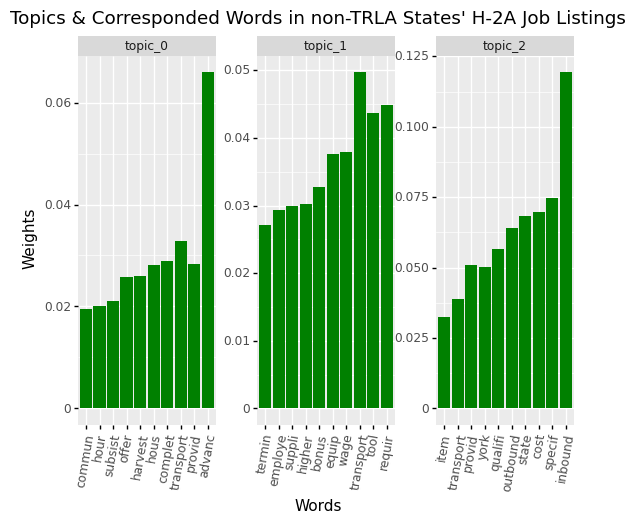

<ggplot: (8769739236515)>

In [40]:
import plotnine
from plotnine import *

ggplot(all_summary_df_non) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="green")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights",title="Topics & Corresponded Words in non-TRLA States' H-2A Job Listings")

In [41]:
## topic modeling (whole document)
 
merged_data = merged_data[merged_data.text_preprocess != ""].copy()

tokenized_text_all = [wordpunct_tokenize(one_text) for one_text in 
                                      merged_data.text_preprocess]

## preprocess and estimate topicmod
### create dictionary
text_proc_dict_all = corpora.Dictionary(tokenized_text_all)
### filter dictionary- using 2% as bounds
text_proc_dict_all.filter_extremes(no_below = round(merged_data.shape[0]*0.02),
                             no_above = round(merged_data.shape[0]*0.98))

### create corpus from dictionary
corpus_fromdict_proc_all = [text_proc_dict_all.doc2bow(one_text) 
                   for one_text in tokenized_text_all]

tfidf_all = models.TfidfModel(corpus_fromdict_proc_all)
corpus_tfidf_all = tfidf[corpus_fromdict_proc_all]

lda_model_tfidf_all = gensim.models.LdaMulticore(corpus_tfidf_all, num_topics=3, id2word=text_proc_dict_all, passes=6,
                                        per_word_topics = True, random_state = 91988)

#print words and topic separate...
topics_all = lda_model_tfidf_all.print_topics(num_words = 10)
for topic in topics_all:
    print(topic)

(0, '0.069*"advanc" + 0.033*"employe" + 0.032*"although" + 0.032*"physic" + 0.029*"reserv" + 0.028*"inbound" + 0.028*"outbound" + 0.028*"legal" + 0.028*"threaten" + 0.028*"right"')
(1, '0.047*"transport" + 0.035*"rule" + 0.029*"requir" + 0.029*"hous" + 0.027*"provid" + 0.025*"offer" + 0.022*"must" + 0.021*"applic" + 0.020*"inbound" + 0.018*"harvest"')
(2, '0.102*"time" + 0.065*"cont" + 0.059*"complet" + 0.057*"vari" + 0.049*"transport" + 0.041*"reimburs" + 0.040*"avail" + 0.038*"begin" + 0.036*"nworker" + 0.027*"provid"')


In [42]:
topics_fromshow2_all = [lda_model_tfidf_all.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]

def df_onetopic(one_listoftup, i):
    words = [one_tup[0] for one_tup in one_listoftup]
    weights = [one_tup[1] for one_tup in one_listoftup]
    words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
    words_weights_df['topic'] = "topic_" + str(i)
    return(words_weights_df)
all_summary_all = []
for i in range(0, len(topics_fromshow2_all)):
    one_summary_all = df_onetopic(topics_fromshow2_all[i], i)
    all_summary_all.append(one_summary_all)
all_summary_df_all = pd.concat(all_summary_all)
all_summary_df_all

,words,weights,topic
0,advanc,0.068731,topic_0
1,employe,0.032710,topic_0
2,although,0.032299,topic_0
3,physic,0.031685,topic_0
4,reserv,0.028534,topic_0
5,inbound,0.028151,topic_0
6,outbound,0.028058,topic_0
7,legal,0.027972,topic_0
8,threaten,0.027624,topic_0
9,right,0.027550,topic_0


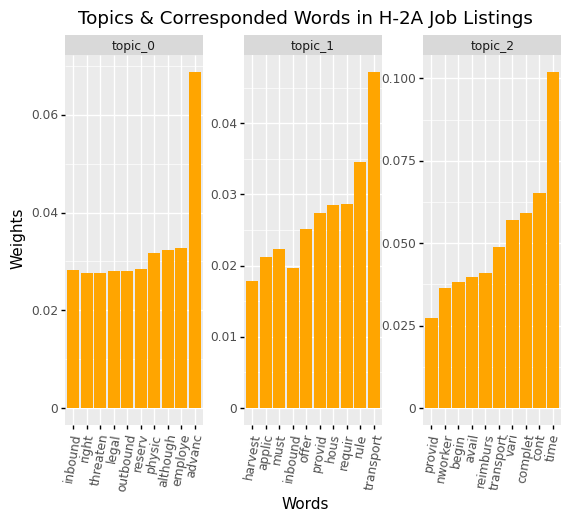

<ggplot: (8769739219035)>

In [43]:
import plotnine
from plotnine import *

ggplot(all_summary_df_all) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="orange")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights",title="Topics & Corresponded Words in H-2A Job Listings")